In [1]:
import pandas as pd

In [7]:


for i in range(1, 7):
    input = f'D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc{i}_set2.csv'
    dataset2= "C:/thesis/climate_bike/bike_updated_MRT.csv"
    output =  f'D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc{i}_set2_dir.csv'
    # Load the CSVs
    df1 = pd.read_csv(input)   # Main dataset
    df2 = pd.read_csv(dataset2)  # Additional data

    join_cols = ['latitude', 'longitude', 'Air_Temp', 'humidity', 'Qs_in']

    columns_to_add = {
        'MRT_C': 'new_MRT_C',
        'direction_raw': 'direction_raw',
        'stationary': 'stationary',
        'direction': 'direction',
        'cardinal_aligned': 'cardinal_aligned'
    }

    # Keep join columns in selection
    df2_subset = df2[join_cols + list(columns_to_add.keys())].copy()
    df2_subset = df2_subset.rename(columns=columns_to_add)

    # Merge using multiple keys
    merged = pd.merge(df1, df2_subset, on=join_cols, how='left')

    def is_near_cardinal(direction, tolerance=10):
        cardinals = [0, 90, 180, 270, 360]
        return any(min(abs(direction - c), 360 - abs(direction - c)) <= tolerance for c in cardinals)

    # Apply to the interpolated direction column
    merged['cardinal_aligned_10'] = merged['direction'].apply(is_near_cardinal)


    # Save to CSV
    merged.to_csv(output, index=False)

KeyError: 'direction'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({
    'font.size': 16,          # Base font size
    'axes.titlesize': 18,     # Title font size
    'axes.labelsize': 16,     # Axis label font size
    'xtick.labelsize': 14,    # X tick label font size
    'ytick.labelsize': 14,    # Y tick label font size
    'legend.fontsize': 14,    # Legend font size
    'legend.title_fontsize': 16  # Legend title font size
})

for i in range(1, 7):
    test_file = f"D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc{i}_set2_dir.csv"
    df = pd.read_csv(test_file)

    # Convert 'under' to boolean
    df['under'] = df['under'].astype(str).str.upper() == 'TRUE'

    # Convert timestamp if available
    if 'TIMESTAMP' in df.columns:
        df['timestamp'] = pd.to_datetime(df['TIMESTAMP'])
        df = df[df['timestamp'].notna()].reset_index(drop=True)
        x_col = 'timestamp'
    else:
        df['Row'] = df.index
        x_col = 'Row'

    # Plot setup
    plt.figure(figsize=(14, 10))

    # Shade background where under == True
    for j in range(len(df)-1):
        if df.loc[j, 'under']:
            plt.axvspan(df.loc[j, x_col], df.loc[j+1, x_col], color='lightblue', alpha=0.3)

    # Define colors and markers
    tmrt_models = {
        '3d1_2': ('#e76f51', '^', '3D Model'),
        'gap1_2': ('#2a9d8f', 's', 'Gap Model'),
        'over1_2': ('#936fac', 'D', 'On-top Model')
    }

    # Plot modeled TMRTs
    for col, (color, marker, custom_label) in tmrt_models.items():
        if col in df.columns:
            plt.scatter(df[x_col], df[col], color=color, label=custom_label, marker=marker, s=40)
            plt.plot(df[x_col], df[col], color=color, linewidth=1, alpha=0.5)

    # Plot observed data
    plt.scatter(df[x_col], df['new_MRT_C'], color='black', label='Observed', marker='o', s=50)
    plt.plot(df[x_col], df['new_MRT_C'], color='black', linewidth=1, alpha=0.5)

    plt.ylim(15, 65)
    plt.xlabel("Time" if x_col == 'timestamp' else "Row Index")
    plt.ylabel("Tmrt Value (°C)")
    plt.legend(title='Tmrt Sources')
    plt.title(f"Location {i}")
    plt.tight_layout()

    # Save the figure
    output_path = f"C:/thesis/figs/evaluation/plot_location_{i}.png"
    plt.savefig(output_path, dpi=300)
    plt.close()

79


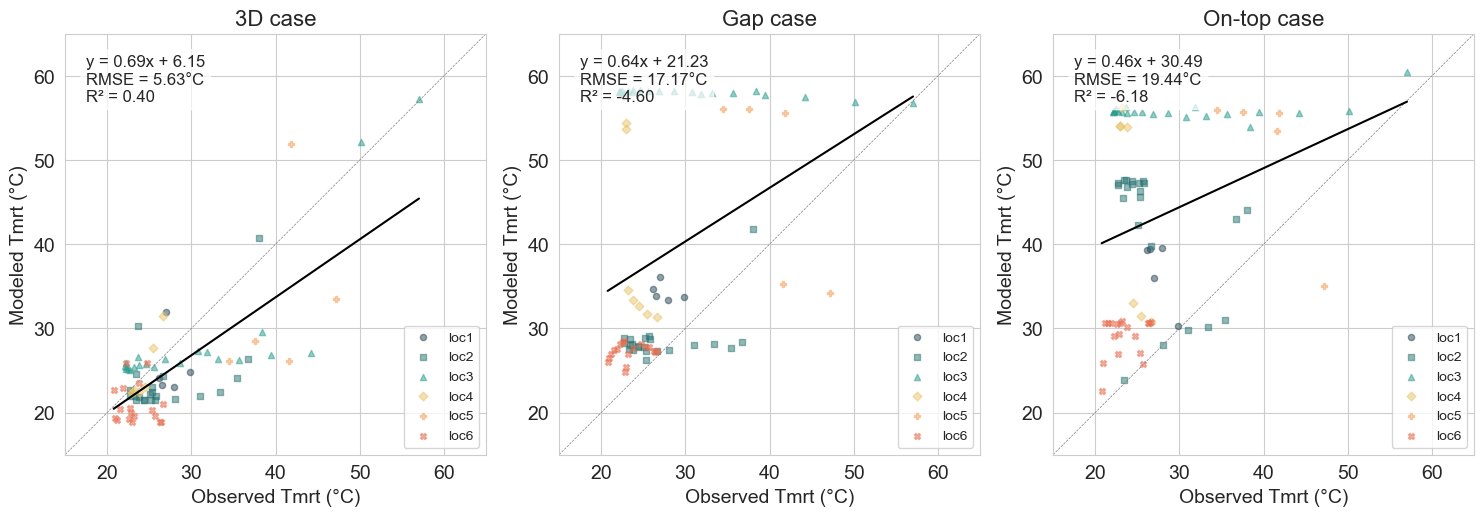

In [3]:
plt.rcParams.update({
    'font.size': 12,          # Base font size
    'axes.titlesize': 16,     # Title font size
    'axes.labelsize': 14,     # Axis label font size
    'xtick.labelsize': 14,    # X tick label font size
    'ytick.labelsize': 14,    # Y tick label font size
    'legend.fontsize': 11,    # Legend font size
    'legend.title_fontsize': 16  # Legend title font size
})

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns

# File paths of the 6 CSV files
file_paths = [
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc1_set2_dir.csv",
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc2_set2_dir.csv",
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc3_set2_dir.csv",
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc4_set2_dir.csv",
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc5_set2_dir.csv",
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc6_set2_dir.csv"
]

# Add source label to each DataFrame before concatenation
df_list = []
for i, file in enumerate(file_paths, start=1):
    df_temp = pd.read_csv(file)
    df_temp['source'] = f'loc{i}'
    df_list.append(df_temp)

df = pd.concat(df_list, ignore_index=True)

# Model columns and observed column
model_cols =  ['3d1_2', 'gap1_2', 'over1_2']
obs_col = 'new_MRT_C'

# Define the boolean condition column
condition_col = 'under'

# Filter the data where the boolean column 'under' is True
df_clean = df[df[condition_col] == True][[obs_col, 'source'] + model_cols].dropna()

# Color and marker mapping for sources
palette = ["#264653", "#287271", "#2a9d8f", "#e9c46a", "#f4a261", "#e76f51"]
sns.set_palette(palette)
colors = palette
markers = ['o', 's', '^', 'D', 'P', 'X']
sources = sorted(df_clean['source'].unique())
source_styles = {src: {'color': c, 'marker': m} for src, c, m in zip(sources, colors, markers)}

# Plot setup
plt.figure(figsize=(15, 5))
plotmin, plotmax = 15, 65

for i, model_col in enumerate(model_cols, start=1):
    ax = plt.subplot(1, len(model_cols), i)

    # Linear regression
    reg = LinearRegression()
    reg.fit(df_clean[[obs_col]], df_clean[model_col])
    slope = reg.coef_[0]
    intercept = reg.intercept_

    # Regression line based on data range
    x_fit = np.linspace(df_clean[obs_col].min(), df_clean[obs_col].max(), 100)
    y_fit = slope * x_fit + intercept

    # Perfect line (y = x) across whole plot
    x_perfect = np.array([plotmin, plotmax])
    y_perfect = x_perfect
    ax.plot(x_perfect, y_perfect, color='gray', linestyle='--',  linewidth=0.5)

    # Regression line
    ax.plot(x_fit, y_fit, color='black')

    # Scatter points by source
    for src in sources:
        subset = df_clean[df_clean['source'] == src]
        ax.scatter(subset[obs_col], subset[model_col],
                   label=src,
                   alpha=0.5,
                   color= source_styles[src]['color'],
                   marker=source_styles[src]['marker'],
                   s=20)

    # Metrics
    rmse = np.sqrt(mean_squared_error(df_clean[obs_col], df_clean[model_col]))
    r2 = r2_score(df_clean[obs_col], df_clean[model_col])
    ax.text(0.05, 0.95,
            f"y = {slope:.2f}x + {intercept:.2f}\nRMSE = {rmse:.2f}°C\nR² = {r2:.2f}",
            transform=ax.transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

    # Labels and aesthetics
    ax.set_xlabel("Observed Tmrt (\N{DEGREE SIGN}C)")
    ax.set_ylabel("Modeled Tmrt (\N{DEGREE SIGN}C)")
    title_map = {
        'gap1_2': 'Gap case',
        'over1_2': 'On-top case',
        '3d1_2': '3D case'
    }
    ax.set_title(title_map.get(model_col, model_col))
    ax.set_xlim([plotmin, plotmax])
    ax.set_ylim([plotmin, plotmax])
    ax.set_aspect('equal', 'box')
    ax.grid(True)
    ax.legend(fontsize='small')

plt.tight_layout()
print(len(df_clean))

output_path = f"C:/thesis/figs/evaluation/plots_under.png"
plt.savefig(output_path, dpi=300)
plt.show()
plt.close()

21


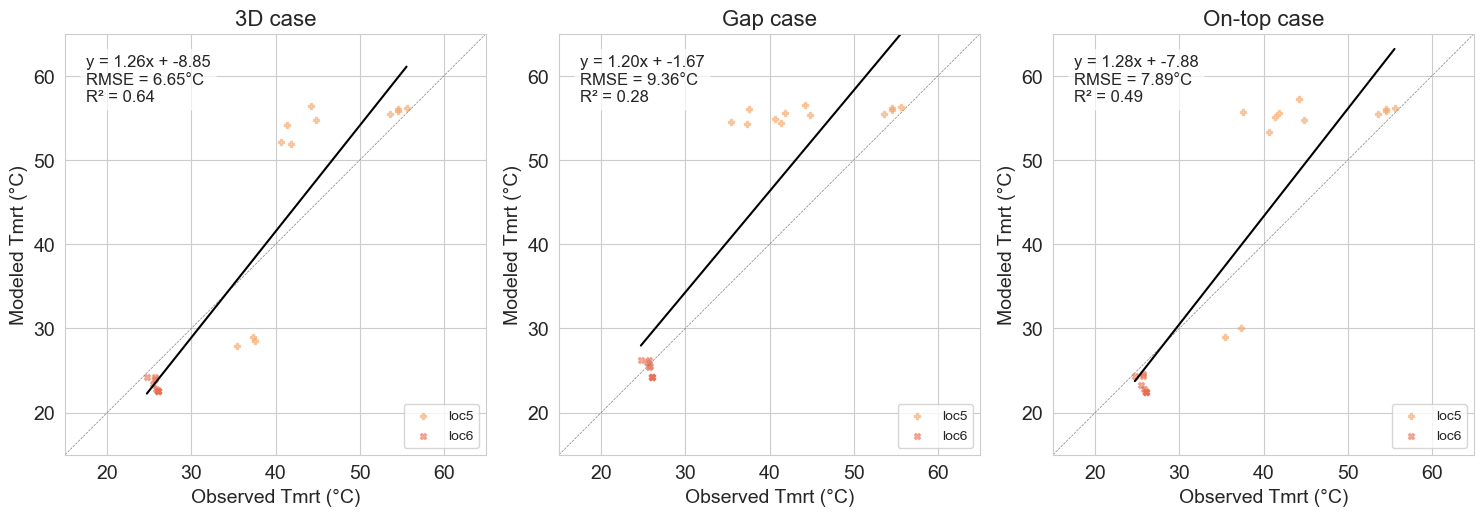

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns



# Add source label to each DataFrame before concatenation
df_list = []
for i, file in enumerate(file_paths, start=1):
    df_temp = pd.read_csv(file)
    df_temp['source'] = f'loc{i}'
    df_list.append(df_temp)

df = pd.concat(df_list, ignore_index=True)

# Model columns and observed column
model_cols = ['3d1_2', 'gap1_2', 'over1_2']
obs_col = 'new_MRT_C'

# Define the boolean condition column
condition_col = 'cardinal_aligned'

# Filter the data where the boolean column 'under' is True
df_clean = df[df[condition_col] == True][[obs_col, 'source'] + model_cols].dropna()

# Color and marker mapping for sources
palette = ["#f4a261", "#e76f51"]
sns.set_palette(palette)
colors = palette
markers = ['P', 'X']
sources = sorted(df_clean['source'].unique())
source_styles = {src: {'color': c, 'marker': m} for src, c, m in zip(sources, colors, markers)}

# Plot setup
plt.figure(figsize=(15, 5))
plotmin, plotmax = 15, 65

for i, model_col in enumerate(model_cols, start=1):
    ax = plt.subplot(1, len(model_cols), i)

    # Linear regression
    reg = LinearRegression()
    reg.fit(df_clean[[obs_col]], df_clean[model_col])
    slope = reg.coef_[0]
    intercept = reg.intercept_

    # Regression line based on data range
    x_fit = np.linspace(df_clean[obs_col].min(), df_clean[obs_col].max(), 100)
    y_fit = slope * x_fit + intercept

    # Perfect line (y = x) across whole plot
    x_perfect = np.array([plotmin, plotmax])
    y_perfect = x_perfect
    ax.plot(x_perfect, y_perfect, color='gray', linestyle='--',  linewidth=0.5)

    # Regression line
    ax.plot(x_fit, y_fit, color='black')

    # Scatter points by source
    for src in sources:
        subset = df_clean[df_clean['source'] == src]
        ax.scatter(subset[obs_col], subset[model_col],
                   label=src,
                   alpha=0.5,
                   color= source_styles[src]['color'],
                   marker=source_styles[src]['marker'],
                   s=20)

    # Metrics
    rmse = np.sqrt(mean_squared_error(df_clean[obs_col], df_clean[model_col]))
    r2 = r2_score(df_clean[obs_col], df_clean[model_col])
    ax.text(0.05, 0.95,
            f"y = {slope:.2f}x + {intercept:.2f}\nRMSE = {rmse:.2f}°C\nR² = {r2:.2f}",
            transform=ax.transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

    # Labels and aesthetics
    ax.set_xlabel("Observed Tmrt (\N{DEGREE SIGN}C)")
    ax.set_ylabel("Modeled Tmrt (\N{DEGREE SIGN}C)")
    ax.set_title(title_map.get(model_col, model_col))
    ax.set_xlim([plotmin, plotmax])
    ax.set_ylim([plotmin, plotmax])
    ax.set_aspect('equal', 'box')
    ax.grid(True)
    ax.legend(fontsize='small')

plt.tight_layout()
print(len(df_clean))
output_path = (f"C:/thesis/figs/evaluation/plots_cardinal.png")
plt.savefig(output_path, dpi=300)
plt.show()
plt.close()

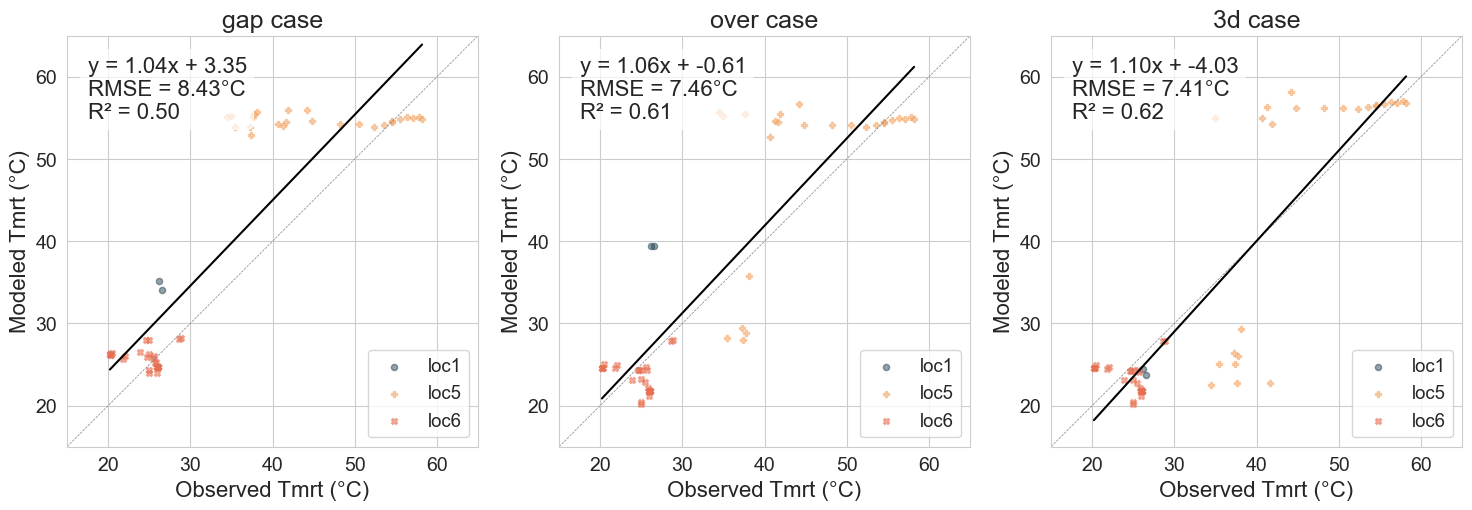

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns

# File paths of the 6 CSV files
file_paths = [
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc1_new.csv",
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc2_new.csv",
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc3_new.csv",
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc4_new.csv",
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc5_new.csv",
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc6_new.csv"
]

# Add source label to each DataFrame before concatenation
df_list = []
for i, file in enumerate(file_paths, start=1):
    df_temp = pd.read_csv(file)
    df_temp['source'] = f'loc{i}'
    df_list.append(df_temp)

df = pd.concat(df_list, ignore_index=True)

# Model columns and observed column
model_cols = ['3d1_2', 'gap1_2', 'over1_2']
obs_col = 'new_MRT_C'

# Define the boolean condition column
condition_col = 'cardinal_aligned_10'

# Filter the data where the boolean column 'under' is True
df_clean = df[df[condition_col] == True][[obs_col, 'source'] + model_cols].dropna()

# Color and marker mapping for sources
palette = ["#264653", "#f4a261", "#e76f51"]
sns.set_palette(palette)
colors = palette
markers = ['o', 'P', 'X']
sources = sorted(df_clean['source'].unique())
source_styles = {src: {'color': c, 'marker': m} for src, c, m in zip(sources, colors, markers)}

# Plot setup
plt.figure(figsize=(15, 10))
plotmin, plotmax = 15, 65

for i, model_col in enumerate(model_cols, start=1):
    ax = plt.subplot(1, len(model_cols), i)

    # Linear regression
    reg = LinearRegression()
    reg.fit(df_clean[[obs_col]], df_clean[model_col])
    slope = reg.coef_[0]
    intercept = reg.intercept_

    # Regression line based on data range
    x_fit = np.linspace(df_clean[obs_col].min(), df_clean[obs_col].max(), 100)
    y_fit = slope * x_fit + intercept

    # Perfect line (y = x) across whole plot
    x_perfect = np.array([plotmin, plotmax])
    y_perfect = x_perfect
    ax.plot(x_perfect, y_perfect, color='gray', linestyle='--',  linewidth=0.5)

    # Regression line
    ax.plot(x_fit, y_fit, color='black')

    # Scatter points by source
    for src in sources:
        subset = df_clean[df_clean['source'] == src]
        ax.scatter(subset[obs_col], subset[model_col],
                   label=src,
                   alpha=0.5,
                   color= source_styles[src]['color'],
                   marker=source_styles[src]['marker'],
                   s=20)

    # Metrics
    rmse = np.sqrt(mean_squared_error(df_clean[obs_col], df_clean[model_col]))
    r2 = r2_score(df_clean[obs_col], df_clean[model_col])
    ax.text(0.05, 0.95,
            f"y = {slope:.2f}x + {intercept:.2f}\nRMSE = {rmse:.2f}°C\nR² = {r2:.2f}",
            transform=ax.transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

    # Labels and aesthetics
    ax.set_xlabel("Observed Tmrt (\N{DEGREE SIGN}C)")
    ax.set_ylabel("Modeled Tmrt (\N{DEGREE SIGN}C)")
    ax.set_title(title_map.get(model_col, model_col))
    ax.set_xlim([plotmin, plotmax])
    ax.set_ylim([plotmin, plotmax])
    ax.set_aspect('equal', 'box')
    ax.grid(True)
    ax.legend(fontsize='small')

plt.tight_layout()
plt.show()

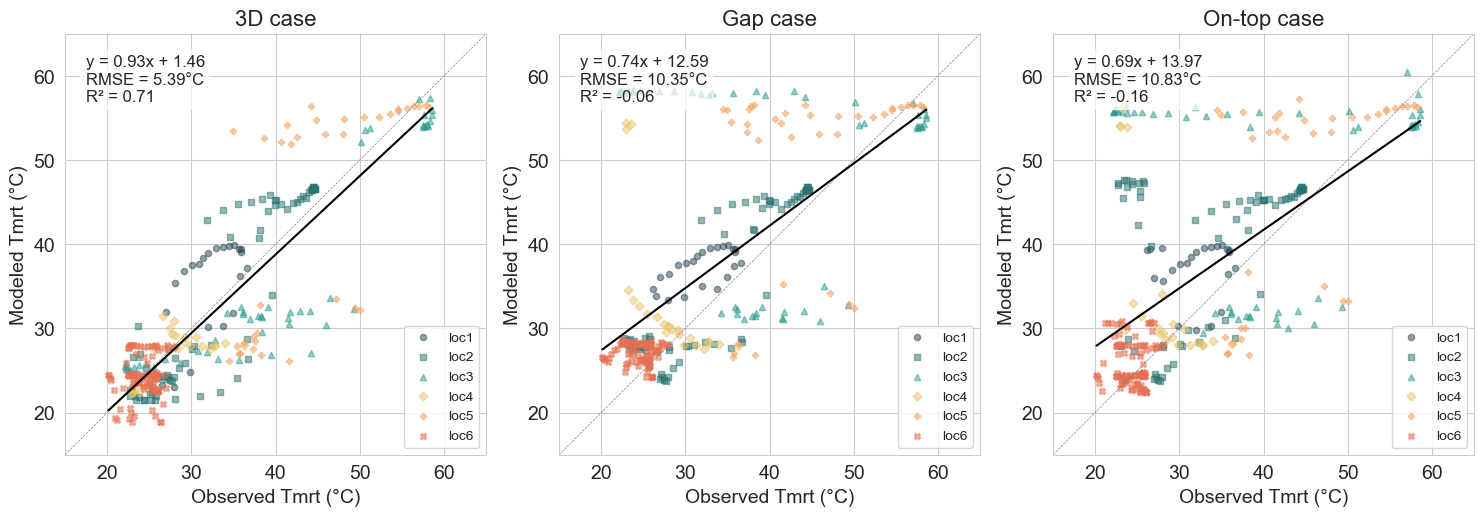

312


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import numpy as np
from matplotlib import colormaps
import matplotlib.colors as mcolors
import seaborn as sns

# Add source label to each DataFrame before concatenation
df_list = []
for i, file in enumerate(file_paths, start=1):
    df_temp = pd.read_csv(file)
    df_temp['source'] = f'loc{i}'
    df_list.append(df_temp)

df = pd.concat(df_list, ignore_index=True)

# Model columns and observed column
model_cols = ['3d1_2', 'gap1_2', 'over1_2']
obs_col = 'new_MRT_C'

# Only keep necessary columns and drop rows with missing values
df_clean = df[[obs_col, 'source'] + model_cols].dropna()

# Color and marker mapping for sources
palette = ["#264653", "#287271", "#2a9d8f", "#e9c46a", "#f4a261", "#e76f51"]
sns.set_palette(palette)
colors = palette
markers = ['o', 's', '^', 'D', 'P', 'X']
sources = sorted(df_clean['source'].unique())
source_styles = {src: {'color': c, 'marker': m} for src, c, m in zip(sources, colors, markers)}

# Plot setup
plt.figure(figsize=(15, 5))
plotmin, plotmax = 15, 65

for i, model_col in enumerate(model_cols, start=1):
    ax = plt.subplot(1, len(model_cols), i)

    # Linear regression
    reg = LinearRegression()
    reg.fit(df_clean[[obs_col]], df_clean[model_col])
    slope = reg.coef_[0]
    intercept = reg.intercept_

    # Regression line based on data range
    x_fit = np.linspace(df_clean[obs_col].min(), df_clean[obs_col].max(), 100)
    y_fit = slope * x_fit + intercept

    # Perfect line (y = x) across whole plot
    x_perfect = np.array([plotmin, plotmax])
    y_perfect = x_perfect
    ax.plot(x_perfect, y_perfect, color='gray', linestyle='--',  linewidth=0.5)

    # Regression line
    ax.plot(x_fit, y_fit, color='black')

    # Scatter points by source
    for src in sources:
        subset = df_clean[df_clean['source'] == src]
        ax.scatter(subset[obs_col], subset[model_col],
                   label=src,
                   alpha=0.5,
                   color= source_styles[src]['color'],
                   marker=source_styles[src]['marker'],
                   s=20)

    # Metrics
    rmse = np.sqrt(mean_squared_error(df_clean[obs_col], df_clean[model_col]))
    r2 = r2_score(df_clean[obs_col], df_clean[model_col])
    ax.text(0.05, 0.95,
            f"y = {slope:.2f}x + {intercept:.2f}\nRMSE = {rmse:.2f}°C\nR² = {r2:.2f}",
            transform=ax.transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

    # Labels and aesthetics
    ax.set_xlabel("Observed Tmrt (\N{DEGREE SIGN}C)")
    ax.set_ylabel("Modeled Tmrt (\N{DEGREE SIGN}C)")
    ax.set_title(title_map.get(model_col, model_col))
    ax.set_xlim([plotmin, plotmax])
    ax.set_ylim([plotmin, plotmax])
    ax.set_aspect('equal', 'box')
    ax.grid(True)
    ax.legend(fontsize='small')

plt.tight_layout()


output_path = f"C:/thesis/figs/evaluation/plots_all.png"
plt.savefig(output_path, dpi=300)
plt.show()
plt.close()

print(len(df_clean))


# Global radiation

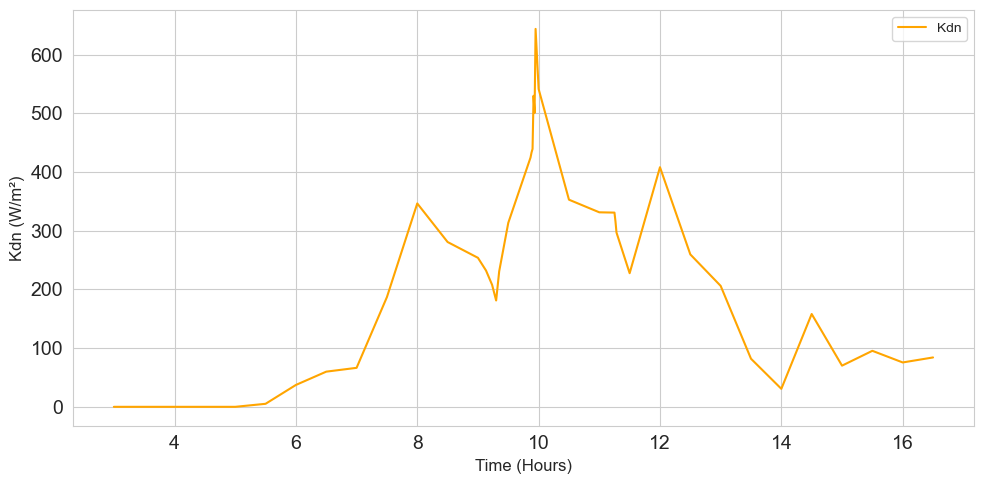

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import time
from datetime import datetime, timedelta

# Load the data into a DataFrame
df = pd.read_csv("D:/Geomatics/thesis/_amsterdamset/12sep/sep12_schip_climatebike_qgis.txt", sep='\\s+')

# Assign column names if needed (only first few are important here)
df.columns = ['year', 'doy', 'hour', 'minute'] + [f'col{i}' for i in range(4, df.shape[1])]

# Extract Kdn (assumed to be at index 13, which is 'col13')
df['kdn'] = df['col14'].astype(float)

# Create datetime from year, doy, hour, minute

df['time'] = df.apply(
    lambda row: time(
        int(row['hour']),
        int(row['minute'])
    ),
    axis=1
)
# Filter out invalid Kdn values (-999)
df = df[df['kdn'] != -999.00]

# Plot
df['time_str'] = df['time'].apply(lambda t: t.strftime('%H:%M'))

df['time_float'] = df['hour'] + df['minute'] / 60

plt.figure(figsize=(10, 5))
plt.plot(df['time_float'], df['kdn'], label='Kdn', color='orange')
plt.xlabel('Time (Hours)')
plt.ylabel('Kdn (W/m²)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()